### Cross Sections

---

#### 1. **Homoskedasticity-Only Standard Errors**
- **Error Structure**: 
  \[
  \text{Var}(\varepsilon) = \sigma^2 \mathbf{I} = 
  \begin{bmatrix}
  \sigma^2 & 0 & \cdots & 0 \\
  0 & \sigma^2 & \cdots & 0 \\
  \vdots & \vdots & \ddots & \vdots \\
  0 & 0 & \cdots & \sigma^2
  \end{bmatrix}.
  \]
- **Assumption**: Errors are uncorrelated and have constant variance: \(\text{Var}(\varepsilon_i) = \sigma^2\), \(\text{Cov}(\varepsilon_i, \varepsilon_j) = 0\) for \(i \neq j\).
- **Example**: Test scores have uniform variability regardless of class sizes, e.g., equally funded schools.

---

#### 2. **Heteroskedasticity-Robust Standard Errors**
- **Error Structure**:
  \[
  \text{Var}(\varepsilon) = 
  \mathbf{\Sigma} = 
  \begin{bmatrix}
  \sigma_1^2 & 0 & \cdots & 0 \\
  0 & \sigma_2^2 & \cdots & 0 \\
  \vdots & \vdots & \ddots & \vdots \\
  0 & 0 & \cdots & \sigma_n^2
  \end{bmatrix}.
  \]
- **Assumption**: Errors are independent, but variances differ across observations: \(\text{Var}(\varepsilon_i) = \sigma_i^2\), \(\text{Cov}(\varepsilon_i, \varepsilon_j) = 0\) for \(i \neq j\).
- **Example**: Test scores show greater variability at larger class sizes, e.g., underfunded schools.

---

#### 3. **Cluster-Robust Standard Errors**
- **Error Structure**:
  \[
  \text{Var}(\varepsilon) = 
  \mathbf{B} = 
  \begin{bmatrix}
  \mathbf{\Sigma}_1 & 0 & \cdots & 0 \\
  0 & \mathbf{\Sigma}_2 & \cdots & 0 \\
  \vdots & \vdots & \ddots & \vdots \\
  0 & 0 & \cdots & \mathbf{\Sigma}_C
  \end{bmatrix}, $\quad
  \mathbf{\Sigma}_c$ = 
  \begin{bmatrix}
  \sigma_{11} & \cdots & \sigma_{1n_c} \\
  \vdots & \ddots & \vdots \\
  \sigma_{n_c1} & \cdots & \sigma_{n_cn_c}
  \end{bmatrix}.
  \]
- **Assumption**: Errors are correlated within clusters (\(\text{Cov}(\varepsilon_i, \varepsilon_j) \neq 0\) for \(i, j\) in the same cluster) but independent across clusters.
- **Example**: Schools within the same district share characteristics, leading to correlated test scores within districts but independence across districts.


,Coefficient,Std Error,t-value,p-value
Homoskedastic,0.818836,0.224900,3.640894,0.000347
Heteroskedastic,0.818836,0.171943,4.762255,0.000002
Cluster,0.818836,0.685158,1.195104,0.232046
HC3,0.818836,0.173841,4.710246,0.000002
HAC,0.818836,0.236946,3.455795,0.000671


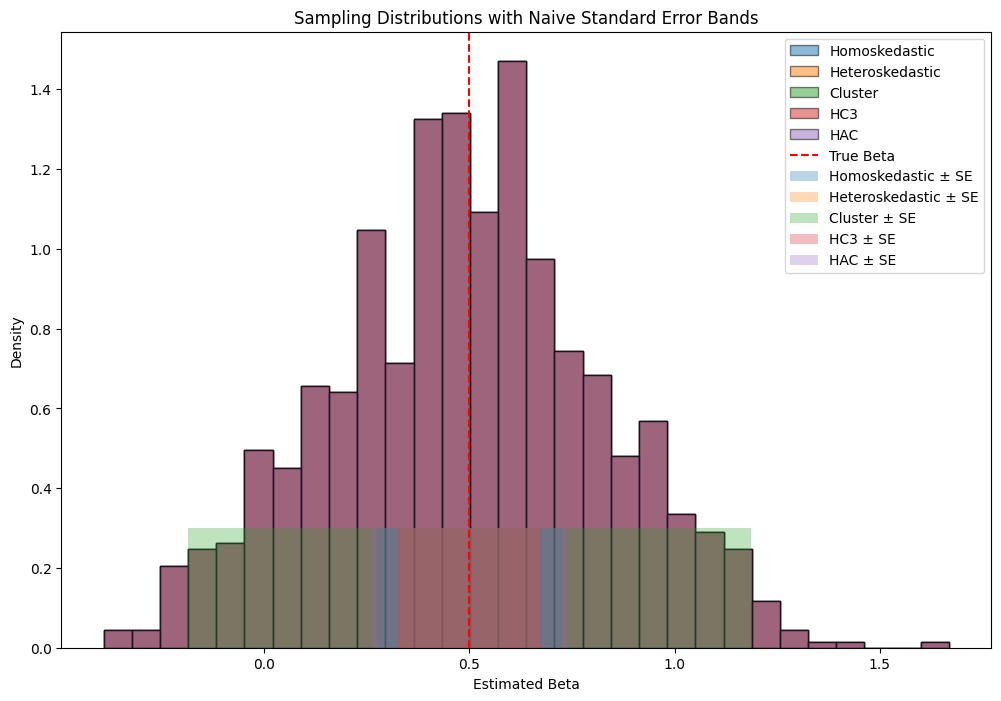

In [40]:
#!/usr/bin/env python

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

np.random.seed(42)

# Parameters
n, n_groups = 200, 10
group_size = n // n_groups
groups = np.repeat(np.arange(n_groups), group_size)
phi, time = 0.9, np.arange(n)
if len(groups) < n:  # Adjust for non-divisibility
    groups = np.append(groups, np.full(n - len(groups), n_groups - 1))

# Generate errors
sigma = 1 + 2 * time / n
errors_clustered = np.zeros(n)
group_effects = np.random.normal(0, 2, n_groups)
for t in range(1, n):
    group = groups[t]
    errors_clustered[t] = (
        phi * errors_clustered[t - 1] * (groups[t - 1] == group)
        + group_effects[group]
        + np.random.normal(0, sigma[t])
    )

# Generate variables
X = np.linspace(0, 10, n)
Y_clustered = 2 + 0.5 * X + errors_clustered
data_clustered = pd.DataFrame({"Y": Y_clustered, "X": X, "group": groups, "time": time})

# Model estimations
model_homosk = sm.OLS(data_clustered["Y"], sm.add_constant(data_clustered["X"])).fit()
model_heterosk = sm.OLS(data_clustered["Y"], sm.add_constant(data_clustered["X"])).fit(cov_type="HC0")
model_cluster = sm.OLS(data_clustered["Y"], sm.add_constant(data_clustered["X"])).fit(
    cov_type="cluster", cov_kwds={"groups": data_clustered["group"]}
)
model_hc3 = sm.OLS(data_clustered["Y"], sm.add_constant(data_clustered["X"])).fit(cov_type="HC3")
model_hac = sm.OLS(data_clustered["Y"], sm.add_constant(data_clustered["X"])).fit(
    cov_type="HAC", cov_kwds={"kernel": "bartlett", "maxlags": 1}, use_t=True
)

# Summarize results
results = pd.DataFrame({
    "Coefficient": [model_homosk.params[1], model_heterosk.params[1], model_cluster.params[1],
                    model_hc3.params[1], model_hac.params[1]],
    "Std Error": [model_homosk.bse[1], model_heterosk.bse[1], model_cluster.bse[1],
                  model_hc3.bse[1], model_hac.bse[1]],
    "t-value": [model_homosk.tvalues[1], model_heterosk.tvalues[1], model_cluster.tvalues[1],
                model_hc3.tvalues[1], model_hac.tvalues[1]],
    "p-value": [model_homosk.pvalues[1], model_heterosk.pvalues[1], model_cluster.pvalues[1],
                model_hc3.pvalues[1], model_hac.pvalues[1]],
}, index=["Homoskedastic", "Heteroskedastic", "Cluster", "HC3", "HAC"])

display(results)

# Simulation for sampling distributions
n_simulations = 1000
true_beta = 0.5
coefficients = {key: [] for key in results.index}

for _ in range(n_simulations):
    errors_sim = np.zeros(n)
    for t in range(1, n):
        group = groups[t]
        errors_sim[t] = (
            phi * errors_sim[t - 1] * (groups[t - 1] == group)
            + group_effects[group]
            + np.random.normal(0, sigma[t])
        )
    Y_sim = 2 + true_beta * X + errors_sim
    data_sim = pd.DataFrame({"Y": Y_sim, "X": X, "group": groups})

    coefficients["Homoskedastic"].append(
        sm.OLS(data_sim["Y"], sm.add_constant(data_sim["X"])).fit().params[1]
    )
    coefficients["Heteroskedastic"].append(
        sm.OLS(data_sim["Y"], sm.add_constant(data_sim["X"])).fit(cov_type="HC0").params[1]
    )
    coefficients["Cluster"].append(
        sm.OLS(data_sim["Y"], sm.add_constant(data_sim["X"])).fit(
            cov_type="cluster", cov_kwds={"groups": data_sim["group"]}
        ).params[1]
    )
    coefficients["HC3"].append(
        sm.OLS(data_sim["Y"], sm.add_constant(data_sim["X"])).fit(cov_type="HC3").params[1]
    )
    coefficients["HAC"].append(
        sm.OLS(data_sim["Y"], sm.add_constant(data_sim["X"])).fit(
            cov_type="HAC", cov_kwds={"kernel": "bartlett", "maxlags": 1}, use_t=True
        ).params[1]
    )

# Plot distributions
coefficients_df = pd.DataFrame(coefficients)
plt.figure(figsize=(12, 8))

# Plot sampling distributions
for key, values in coefficients.items():
    plt.hist(values, bins=30, alpha=0.5, label=key, density=True, edgecolor="black")

# True beta value
plt.axvline(true_beta, color="red", linestyle="--", label="True Beta")

# Add vertical error bands (±1 standard error)
se_values = {
    "Homoskedastic": model_homosk.bse[1],
    "Heteroskedastic": model_heterosk.bse[1],
    "Cluster": model_cluster.bse[1],
    "HC3": model_hc3.bse[1],
    "HAC": model_hac.bse[1],
}

for i, (key, se) in enumerate(se_values.items()):
    plt.fill_betweenx(
        y=[0, 0.3],  # Adjust max y-axis for clarity
        x1=true_beta - se,
        x2=true_beta + se,
        alpha=0.3,
        label=f"{key} ± SE"
    )

# Labels and legend
plt.title("Sampling Distributions with Naive Standard Error Bands")
plt.xlabel("Estimated Beta")
plt.ylabel("Density")
plt.legend()
plt.show()



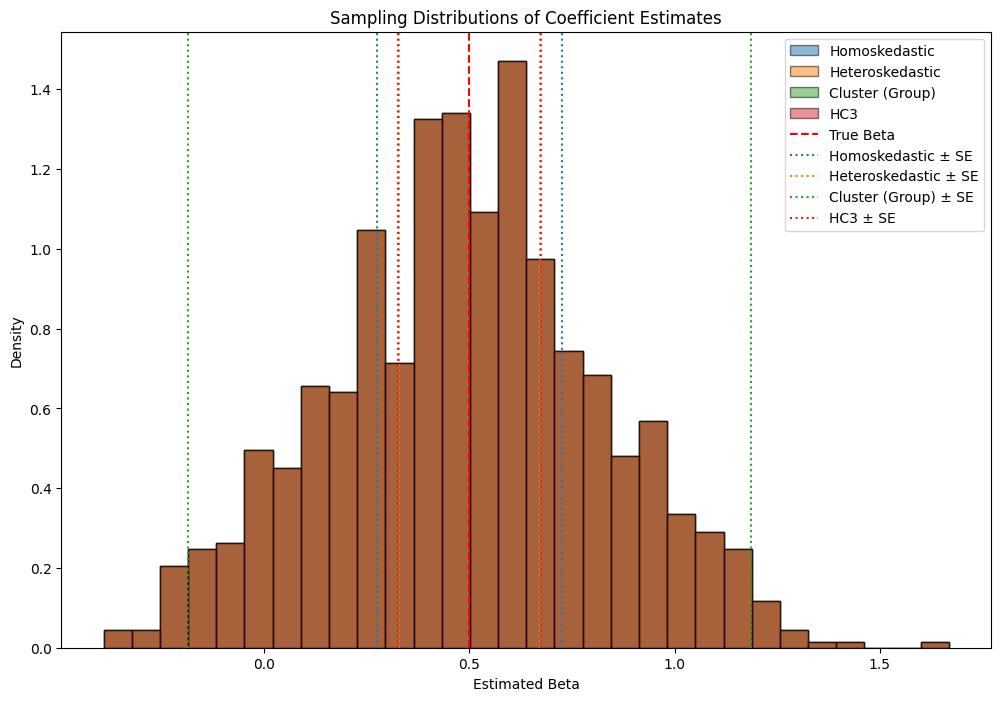

In [37]:
import matplotlib.pyplot as plt

# Simulation parameters
n_simulations = 1000
true_beta = 0.5
coefficients = {"Homoskedastic": [], "Heteroskedastic": [], "Cluster (Group)": [], "HC3": []}

# Run simulation
for _ in range(n_simulations):
    # Generate new errors and outcomes for each simulation
    errors_sim = np.zeros(n)
    for t in range(1, n):
        group = groups[t]
        errors_sim[t] = (
            phi * errors_sim[t - 1] * (groups[t - 1] == group)
            + group_effects[group]
            + np.random.normal(0, sigma[t])
        )
    Y_sim = 2 + true_beta * X + errors_sim

    # Create DataFrame for simulation
    data_sim = pd.DataFrame({"Y": Y_sim, "X": X, "group": groups, "time": time})

    # Estimate models
    model_homosk_sim = sm.OLS(data_sim["Y"], sm.add_constant(data_sim["X"])).fit()
    model_heterosk_sim = sm.OLS(data_sim["Y"], sm.add_constant(data_sim["X"])).fit(cov_type='HC0')
    model_cluster_sim = sm.OLS(data_sim["Y"], sm.add_constant(data_sim["X"])).fit(
        cov_type='cluster', cov_kwds={'groups': data_sim['group']}
    )
    model_hc3_sim = sm.OLS(data_sim["Y"], sm.add_constant(data_sim["X"])).fit(cov_type='HC3')

    # Store coefficients
    coefficients["Homoskedastic"].append(model_homosk_sim.params[1])
    coefficients["Heteroskedastic"].append(model_heterosk_sim.params[1])
    coefficients["Cluster (Group)"].append(model_cluster_sim.params[1])
    coefficients["HC3"].append(model_hc3_sim.params[1])

# Convert to DataFrame
coefficients_df = pd.DataFrame(coefficients)

# Plot the sampling distributions
plt.figure(figsize=(12, 8))

for i, (key, values) in enumerate(coefficients.items()):
    plt.hist(
        values,
        bins=30,
        alpha=0.5,
        label=f"{key}",
        density=True,
        edgecolor="black",
    )

# True beta value
plt.axvline(true_beta, color="red", linestyle="--", label="True Beta")

# Add vertical bars for standard errors from the first run
se_values = {
    "Homoskedastic": model_homosk_clustered.bse[1],
    "Heteroskedastic": model_heterosk_clustered.bse[1],
    "Cluster (Group)": model_cluster_group.bse[1],
    "HC3": model_hc3_clustered.bse[1],
}

for i, (key, se) in enumerate(se_values.items()):
    plt.axvline(
        true_beta + se,
        color=f"C{i}",
        linestyle=":",
        label=f"{key} ± SE",
    )
    plt.axvline(
        true_beta - se,
        color=f"C{i}",
        linestyle=":",
    )

# Add labels and legend
plt.title("Sampling Distributions of Coefficient Estimates")
plt.xlabel("Estimated Beta")
plt.ylabel("Density")
plt.legend()
plt.show()


### Panel Data

In [43]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.sandwich_covariance import cov_cluster

# Set parameters
np.random.seed(42)
N = 50  # Number of individuals
T = 10   # Number of time periods
num_simulations = 5000  # Number of simulations

# Placeholder arrays to store results
beta_estimates = np.zeros((3, num_simulations))
se_estimates = {
    'Firm Cluster': np.zeros((3, num_simulations)),
    'Time Cluster': np.zeros((3, num_simulations)),
    'Firm-Time Cluster': np.zeros((3, num_simulations))
}

# Function to calculate clustered standard errors
def calculate_clustered_se(model, clusters):
    return np.sqrt(np.diag(cov_cluster(model, clusters)))

# Loop over simulations
for sim in range(num_simulations):
    # Generate panel data
    data = {
        'individual': np.repeat(np.arange(N), T),
        'time': np.tile(np.arange(T), N),
        'x': np.random.normal(size=N * T),
    }
    data['firm_effect'] = np.random.normal(size=N).repeat(T)  # Individual-specific component
    data['time_effect'] = np.tile(np.random.normal(size=T), N)  # Time-specific component
    data['noise'] = np.random.normal(size=N * T)               # Pure noise

    # Case 1: Individual-specific error
    data['y_case1'] = 2 * data['x'] + data['firm_effect'] + data['noise']

    # Case 2: Time-specific error
    data['y_case2'] = 2 * data['x'] + data['time_effect'] + data['noise']

    # Case 3: Both firm and time effects
    data['y_case3'] = 2 * data['x'] + data['firm_effect'] + data['time_effect'] + data['noise']

    # Convert to DataFrame
    df = pd.DataFrame(data)

    # Analyze the three cases
    for i, y_col in enumerate(['y_case1', 'y_case2', 'y_case3']):
        # Fit OLS model
        model = sm.OLS(df[y_col], sm.add_constant(df['x'])).fit()

        # Store beta estimates
        beta_estimates[i, sim] = model.params['x']

        # Calculate and store clustered SEs
        se_estimates['Firm Cluster'][i, sim] = calculate_clustered_se(model, df['individual'])[1]
        se_estimates['Time Cluster'][i, sim] = calculate_clustered_se(model, df['time'])[1]
        se_estimates['Firm-Time Cluster'][i, sim] = calculate_clustered_se(
            model, pd.MultiIndex.from_arrays([df['individual'], df['time']])
        )[1]

# Compute empirical standard deviations (true SEs) of beta estimates
true_se = beta_estimates.std(axis=1)

# Compute average estimated SEs from different clustering methods
avg_se = {
    key: se_estimates[key].mean(axis=1)
    for key in se_estimates
}

# Create DataFrame for comparison
comparison_df = pd.DataFrame({
    'True SE': true_se,
    'Firm Cluster SE': avg_se['Firm Cluster'],
    'Time Cluster SE': avg_se['Time Cluster'],
    'Firm-Time Cluster SE': avg_se['Firm-Time Cluster']
}, index=['Case 1', 'Case 2', 'Case 3'])

# Display the results
display(comparison_df)


,True SE,Firm Cluster SE,Time Cluster SE,Firm-Time Cluster SE
Case 1,0.063624,0.062056,0.061566,0.062842
Case 2,0.062602,0.060819,0.057490,0.061099
Case 3,0.076471,0.074880,0.072176,0.075532
